In [28]:
import tensorflow as tf
import numpy as np
import scipy.io as io
from time import time

import scipy.signal as signal
import scipy
from model.filter import filtfilt

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 10, 5
matplotlib.rcParams.update({'font.size': 12})

from tensorflow.python.ops import gen_array_ops

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
def loadmat(id):
    fname = "../validation/A%05d.mat"%id
    y_val = io.loadmat(fname)['val'][0]
    return y_val

In [3]:
tf.reset_default_graph()
y = tf.placeholder(tf.float32, shape=[None, None], name='input')

#convenience functions
fs = 300.

def getconst(constant, **kwargs):
    return tf.constant(constant, dtype=tf.float32, **kwargs)

In [18]:
def rpeakdetect(
    ECG,  # The raw ECG signal
    rate,  # Sampling rate in HZ
    # Window size in seconds to use for
    ransac_window_size=5.0,
    # Low frequency of the band pass filter
    lowfreq=5.0,
    # High frequency of the band pass filter
    highfreq=15.0,
):
    ransac_window_size = int(ransac_window_size * rate)
        
    lowpass = signal.butter(1, highfreq / (rate / 2.0), 'low')
    highpass = signal.butter(1, lowfreq / (rate / 2.0), 'high')
    
    def diff(x):
        return x[:,1:]-x[:,:-1]
    
    with tf.name_scope('lowpass'):
        b_LPF = getconst(lowpass[0])
        a_LPF = getconst(lowpass[1])
        ECG_low = filtfilt(b_LPF, a_LPF, ECG)

    with tf.name_scope('highpass'):
        b_HPF = getconst(highpass[0])
        a_HPF = getconst(highpass[1])
        ECG_band = filtfilt(b_HPF, a_HPF, ECG_low)

    # Square (=signal power) of the first difference of the signal
    with tf.name_scope('diff_power'):
        dECG = diff(ECG_band)
        dECG_power = dECG ** 2
    
    with tf.name_scope('thres_norm_estimation'):
        batch_size = tf.shape(dECG_power)[0]
        sequence_length = tf.shape(dECG_power)[1]
        thresholds = tf.zeros(dtype=tf.float32, shape=[batch_size, 1], name='thresholds_init')
        max_powers = tf.zeros(dtype=tf.float32, shape=[batch_size, 1], name='max_powers_init')
        
        def body(thresholds, max_powers, i):
            d = dECG_power[:, i * ransac_window_size : (i + 1) * ransac_window_size]
            _, var = tf.nn.moments(d,axes=[1], name='variance')
            thresholds = tf.concat([thresholds, 0.5 * tf.sqrt(var)], axis=1, name='concat_thresholds')
            max_value = tf.reduce_max(d, axis=1, name='max')
            max_powers = tf.concat([max_powers, max_value], axis=1, name='concat_max_powers')
            return thresholds, max_powers, i+1

        def cond(thresholds, max_powers, i):
            return i < sequence_length // ransac_window_size

        thresholds, max_powers, _ = tf.while_loop(cond,
                                                  body,
                                                  [thresholds, max_powers, 0],
                                                  shape_invariants=[
                                                      tf.TensorShape([None, None]),
                                                      tf.TensorShape([None, None]),
                                                      tf.TensorShape([])
                                                  ])
        thresholds = thresholds[:,1:]
        max_powers = max_powers[:,1:]
        
        m = (tf.shape(thresholds)[1] + 1)//2
        threshold_list = tf.nn.top_k(thresholds, m, name='calc_treshold').values[:,m-1]
        max_power_list = tf.nn.top_k(max_powers, m, name='median_maxpower').values[:,m-1]
        
    with tf.name_scope('thresholding'):
        shift_mesh = tf.transpose(tf.reshape(tf.tile(threshold_list, [sequence_length]), 
                                             shape=[1,sequence_length,batch_size]), name='shift_mesh')
        dECG_power_shifted = dECG_power - shift_mesh
        dECG_power_thres = tf.where(
            dECG_power_shifted < 0,
            tf.zeros_like(dECG_power),
            dECG_power,
            name='thresholding')

    with tf.name_scope('normalization'):
        scale_mesh = tf.transpose(tf.reshape(tf.tile(max_power_list, [sequence_length]), 
                                             shape=[1,sequence_length,batch_size]), name='scale_mesh')
        dECG_power_thres_norm = dECG_power_thres / scale_mesh
            
        dECG_power_thres_norm = tf.where(
            dECG_power_thres_norm > 1.,
            tf.ones_like(dECG_power_thres_norm),
            dECG_power_thres_norm,
            name='cut_off_high_values')
        dECG_power_thres_norm_square = dECG_power_thres_norm ** 2

        
    with tf.name_scope('average_smoothing'):
        # Average smoothing
        mean_window_len = int(rate * 0.125 + 1)
        kernel = [1.0 / mean_window_len] * mean_window_len
        avg_kernel = tf.constant(kernel, shape=[mean_window_len, 1, 1], name='average_smoothing_kernel')
        
        shannon_energy = -dECG_power_thres_norm_square * tf.log(dECG_power_thres_norm_square)
        shannon_energy = tf.where(
            tf.is_nan(shannon_energy),
            tf.zeros_like(shannon_energy),
            shannon_energy,
            name='remove_NaN')
        shannon_energy = tf.reshape(shannon_energy, shape=[batch_size, sequence_length, 1])
        lp_energy_avg = tf.nn.conv1d(shannon_energy, avg_kernel, stride=1, padding='SAME', name='average_smoothing')
        
    with tf.name_scope('gaussian_blur'):
        std = fs / 8
        truncate = 4.0
        M = int(truncate * std + 0.5) +1
        gaussian = signal.gaussian(M,std)
        gaussian /= np.sum(gaussian)
        gaussian_kernel = tf.constant(gaussian, shape=[len(gaussian), 1, 1], dtype=tf.float32, name='gaussian_kernel')

        lp_energy_avg_gauss = tf.nn.conv1d(lp_energy_avg, gaussian_kernel, stride=1, padding='SAME', name='gaussian_blur')
        
    with tf.name_scope('peak_detection'):
        lp_energy_diff = diff(lp_energy_avg_gauss)

        steps = tf.where(
            lp_energy_diff > 0,
            tf.ones_like(lp_energy_diff),
            -tf.ones_like(lp_energy_diff),
            name='convert_to_step_function')
        zero_crossings = diff(steps)
        
    return ECG_band,dECG,dECG_power,dECG_power_thres,dECG_power_thres_norm,dECG_power_thres_norm_square,shannon_energy,lp_energy_avg,lp_energy_avg_gauss,lp_energy_diff,zero_crossings

In [19]:
def peak_index(zero_crossings):
    return tf.where(zero_crossings < -1, name='get_indexes_of_peaks')

In [20]:
def get_BPM(zero_crossings, fs=300.):
    batch_size = tf.shape(zero_crossings)[0]
    RR = tf.zeros([1], name='BPM')
    def body(RR, i):
        peak_indexes = tf.cast(tf.where(zero_crossings[i] < -1), dtype=tf.float32)
        RR_new = tf.reduce_mean(peak_indexes[1:]-peak_indexes[:-1],name='reduce_mean_diff')
        RR_new = tf.reshape(RR_new, [1])
        RR = tf.concat([RR, RR_new], axis=0)
        return RR, i+1
    def cond(BPM, i):
        return i < batch_size
    RR, _ = tf.while_loop(cond, body, [RR, 0],shape_invariants=[
                                                      tf.TensorShape([None]),
                                                      tf.TensorShape([])
                                                  ])
    BPM = 60. / (RR[1:] / fs)
    return BPM, RR[1:]

In [37]:
result = rpeakdetect(y, fs)
test = peak_index(zero_crossings)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
data1 = loadmat(180)
data2 = loadmat(170)
t = time()
res = sess.run(result, {y:[data1]})
time() - t

3.604043960571289

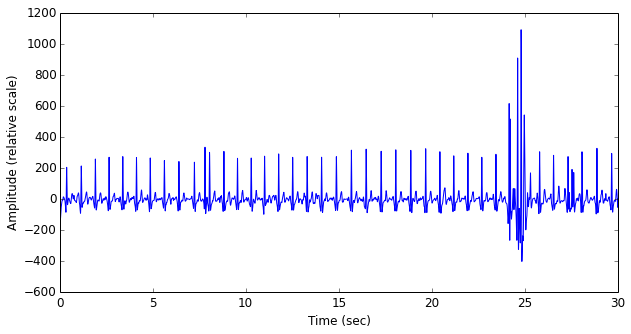

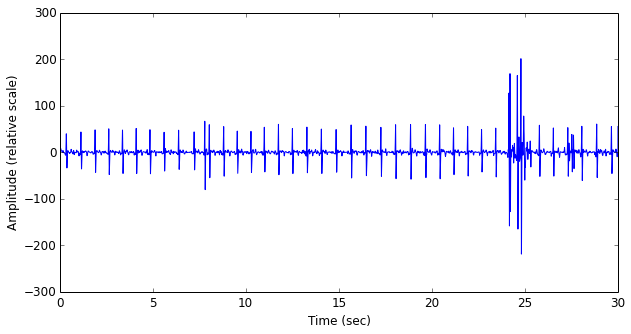

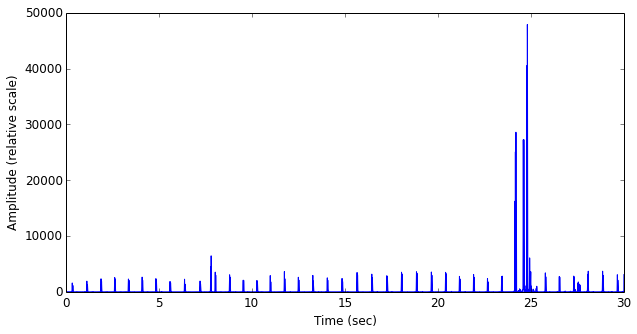

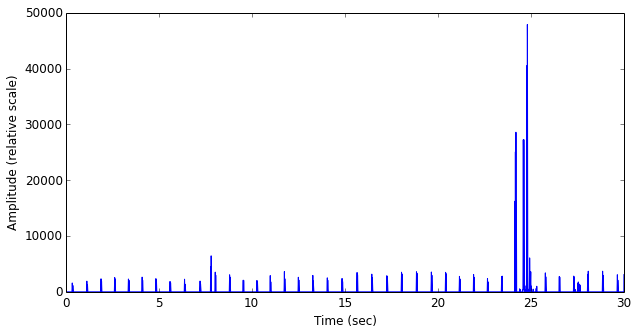

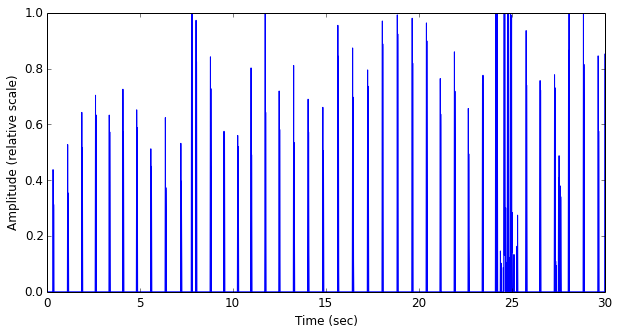

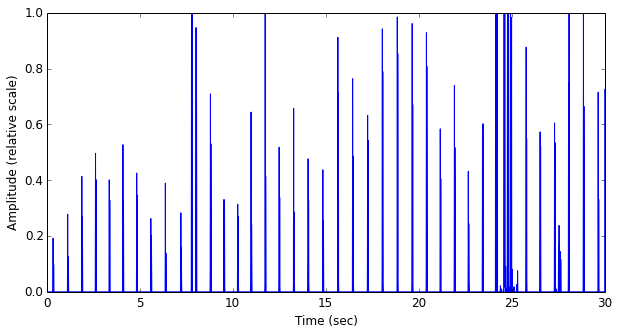

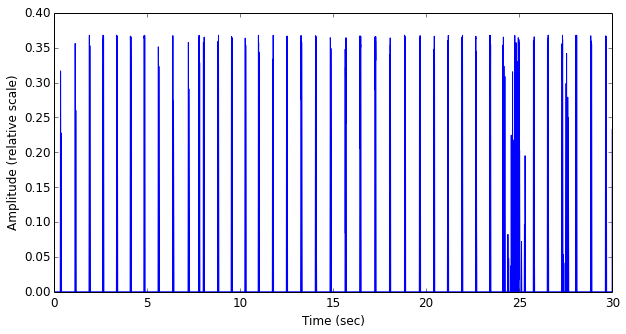

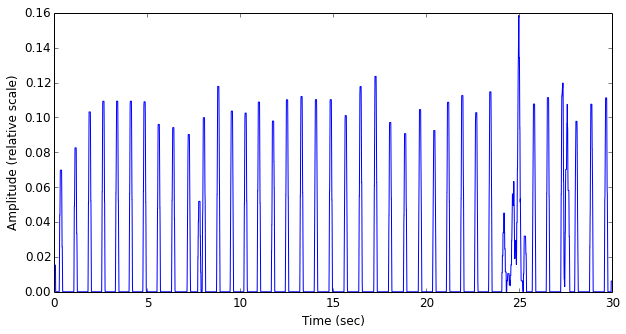

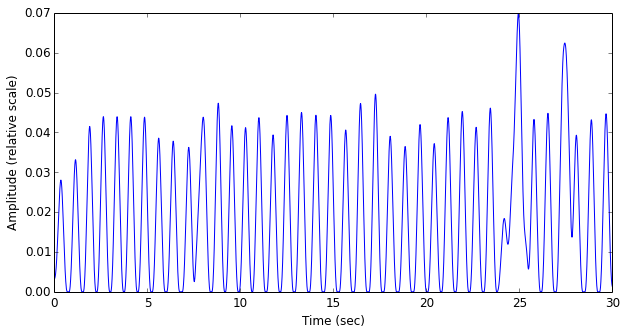

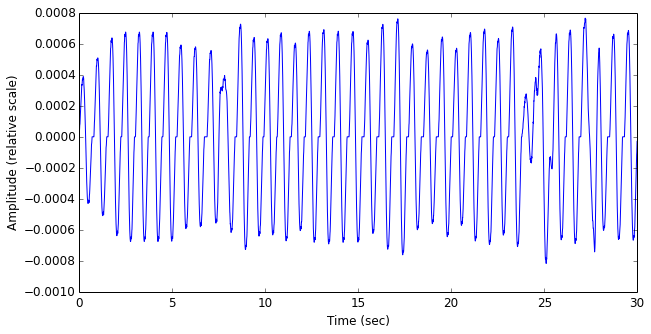

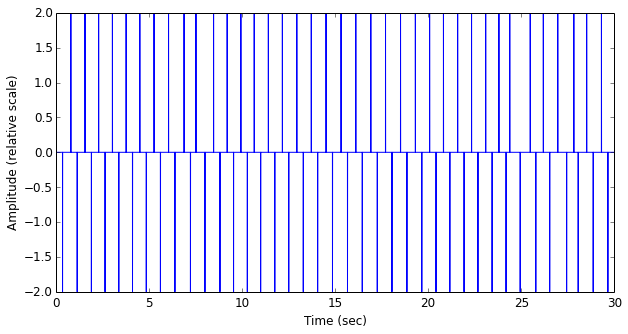

In [38]:
dt = 1.0 / fs
for i in range(len(res)):
    t = np.linspace(0, len(res[i][0,:,0]) * dt, len(res[i][0,:,0]))
    plt.plot(t,res[i][0,:,0])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude (relative scale)')
    plt.xlim(0, t[-1])
    plt.show()

In [43]:
def plot_peak_detection(ecg, peaks, rate):
    import matplotlib.pyplot as plt
    dt = 1.0 / rate
    t = np.linspace(0, len(ecg) * dt, len(ecg))
    plt.plot(t, ecg)
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude (relative scale)')
    plt.xlim(0, t[-1])

    plt.scatter(t[peaks], ecg[peaks+2], color='red')
    plt.show(block=False)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


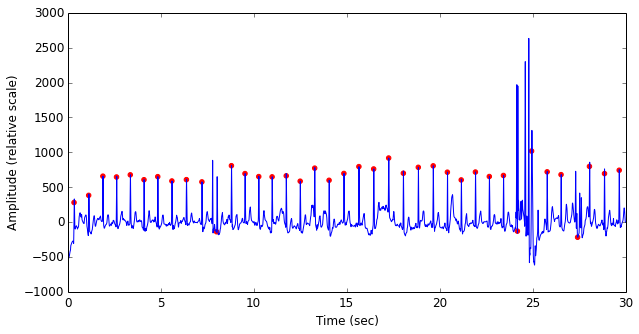

In [45]:
plot_peak_detection(data1, detect_beats(data1,fs), fs)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


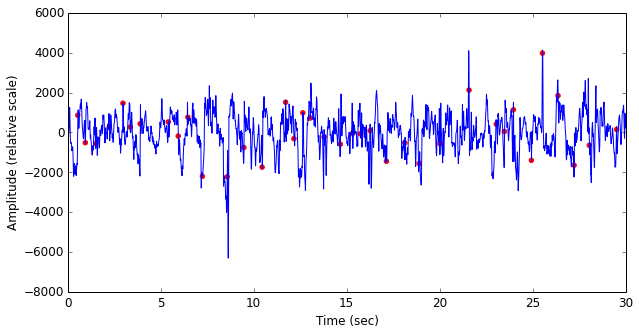

In [48]:
data = loadmat(1246)
plot_peak_detection(data, detect_beats(data,fs), fs)

In [41]:
def detect_beats(
    ecg,  # The raw ECG signal
    rate,  # Sampling rate in HZ
    # Window size in seconds to use for
    ransac_window_size=5.0,
    # Low frequency of the band pass filter
    lowfreq=5.0,
    # High frequency of the band pass filter
    highfreq=15.0,
):
    """
    ECG heart beat detection based on
    http://link.springer.com/article/10.1007/s13239-011-0065-3/fulltext.html
    with some tweaks (mainly robust estimation of the rectified signal
    cutoff threshold).
    """

    ransac_window_size = int(ransac_window_size * rate)

    lowpass = signal.butter(1, highfreq / (rate / 2.0), 'low')
    highpass = signal.butter(1, lowfreq / (rate / 2.0), 'high')
    # TODO: Could use an actual bandpass filter
    ecg_low = signal.filtfilt(*lowpass, x=ecg)
    ecg_band = signal.filtfilt(*highpass, x=ecg_low)

    # Square (=signal power) of the first difference of the signal
    decg = np.diff(ecg_band)
    decg_power = decg**2

    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(len(decg_power) // ransac_window_size):
        sample = slice(i * ransac_window_size, (i + 1) * ransac_window_size)
        d = decg_power[sample]
        thresholds.append(0.5 * np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5 * np.std(decg_power)
    threshold = np.median(thresholds)
    max_power = np.median(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power /= max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2

    shannon_energy = -square_decg_power * np.log(square_decg_power)
    shannon_energy[~np.isfinite(shannon_energy)] = 0.0

    mean_window_len = int(rate * 0.125 + 1)
    lp_energy = np.convolve(
        shannon_energy, [
            1.0 / mean_window_len] * mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)

    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, rate / 8.0)
    lp_energy_diff = np.diff(lp_energy)

    zero_crossings = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    zero_crossings = np.flatnonzero(zero_crossings)
    zero_crossings -= 1
    return zero_crossings

In [350]:
print(res)
print(detect_beats(ecg, fs))

[[[ 0.14625782]
  [ 0.06642814]
  [ 0.02450756]
  ..., 
  [ 0.        ]
  [ 0.        ]
  [ 0.72548163]]]
[ 0.02719274  0.02145137  0.01203898 ...,  0.          0.          0.        ]


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply


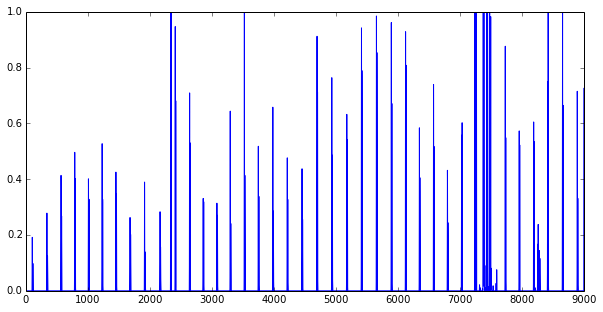

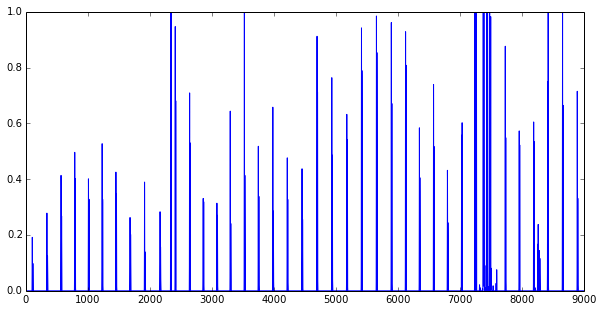

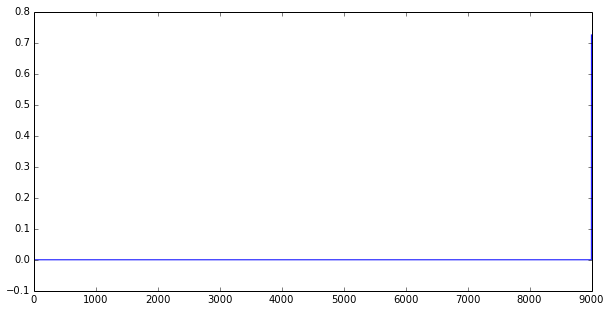

In [351]:
bultin = detect_beats(ecg, fs)
plt.plot(res[0,:,0])
plt.show()
plt.plot(bultin)
plt.show()
plt.plot(res[0,:,0]-bultin)
plt.show()

# Marci's solutions

In [56]:
def detect_beats_tf(
        y,    # The raw ECG signal
        rate=fs,    # Sampling rate in HZ
        ):
    
    lowfreq = 5.
    highfreq = 15.
    lowpass = signal.butter(4, highfreq/(rate/2.), 'low')
    highpass = signal.butter(4, lowfreq/(rate/2), 'high')

    with tf.name_scope('lowpass'):
        b_LPF = getconst(lowpass[0])
        a_LPF = getconst(lowpass[1])
        y_LP = filtfilt(b_LPF, a_LPF, y)

    with tf.name_scope('highpass'):
        b_HPF = getconst(highpass[0])
        a_HPF = getconst(highpass[1])
        y_BAND = filtfilt(b_HPF, a_HPF, y_LP)
        
    with tf.name_scope('diff_power'):
        b_DEV = getconst([1/3.6, 0, 1/8, 0, -1/8, 0, -1/3.6])
        a_DEV = getconst([1, 0, 0, 0, 0])
        y_DEV = filtfilt(b_DEV, a_DEV, y_BAND)
        y_DPOW = y_DEV ** 2
    
    with tf.name_scope('smoothing'):
        y_SHANNON = y_DPOW * tf.log(y_DPOW)
        y_SHANNON = tf.where(tf.is_nan(y_SHANNON), tf.zeros_like(y_SHANNON), y_SHANNON)
        y_LP = filtfilt(b_LPF, a_LPF, y_SHANNON)
        
    max_RR_delay = int(1.2 * rate) #  48 BPM
    min_RR_delay = int(0.4 * rate) # 150 BPM
    
    # Peak detection
    batch_size = tf.shape(y_LP)[0]
    sequence_length = tf.shape(y_LP)[1]
    R_peaks = tf.zeros(dtype=tf.int64, shape=[batch_size, 1], name='R_peaks_zeros_init')

    def body(R_peaks, t):
        curr_R_peak = tf.argmax(y_LP[:,t:t+max_RR_delay], axis=1, name='curr_R_peak')
        t_shift = tf.ones(tf.shape(curr_R_peak),dtype=tf.int32, name='time_shift') * t
        t_shift = tf.cast(t_shift, dtype=tf.int64)
        R_peaks = tf.concat([R_peaks, curr_R_peak+t_shift], axis=1, name='R_peaks')

        t += min_RR_delay
        return R_peaks, t

    def cond(R_peaks, t):
        return t < sequence_length - max_RR_delay

    peaks_duplicate,_ = tf.while_loop(cond, 
                                    body, 
                                    [R_peaks, 0],
                                    shape_invariants=[
                                        tf.TensorShape([None, None]),
                                        tf.TensorShape([])
                                    ])
    """
    i = tf.constant(0)
    peaks_unique = tf.Variable([])
    indx = tf.Variable([])

    def body2(i, peaks_unique, indx):                                               
        peaks_temp, indx_temp, _ = tf.unique_with_counts(peaks_duplicate[i])
        return i+1, peaks_unique, indx
    
    def cond2(i, peaks_unique, indx):
        return i < batch_size

    _, peaks_unique, indx = tf.while_loop(cond2,
                                          body2,
                                          [i, peaks_unique, indx],
                                          shape_invariants=[
                                              i.get_shape(),
                                              peaks_unique.get_shape(), 
                                              indx.get_shape()
                                          ])
    
    BPM = tf.concat([tf.unique_with_counts(p) 
                     for p in tf.unstack(peaks_duplicate, num=batch_size)])
    """
    
    peaks_unique, indx, _ = tf.unique_with_counts(peaks_duplicate)
    BPM = indx[-1] / tf.to_float(sequence_length) * 60. / rate
    return peaks_unique, BPM

## Old implementation

In [ ]:
def detect_beats_tf(
        y,    # The raw ECG signal
        rate=fs,    # Sampling rate in HZ
        ):
    
    lowfreq = 5.
    highfreq = 15.
    lowpass = signal.butter(4, highfreq/(rate/2.), 'low')
    highpass = signal.butter(4, lowfreq/(rate/2), 'high')

    with tf.name_scope('lowpass'):
        b_LPF = getconst(lowpass[0])
        a_LPF = getconst(lowpass[1])
        y_LP = filtfilt(b_LPF, a_LPF, y)

    with tf.name_scope('highpass'):
        b_HPF = getconst(highpass[0])
        a_HPF = getconst(highpass[1])
        y_BAND = filtfilt(b_HPF, a_HPF, y_LP)
        
    with tf.name_scope('diff_power'):
        b_DEV = getconst([1/3.6, 0, 1/8, 0, -1/8, 0, -1/3.6])
        a_DEV = getconst([1, 0, 0, 0, 0])
        y_DEV = filtfilt(b_DEV, a_DEV, y_BAND)
        y_DPOW = y_DEV ** 2
    
    with tf.name_scope('smoothing'):
        y_SHANNON = y_DPOW * tf.log(y_DPOW)
        y_SHANNON = tf.where(tf.is_nan(y_SHANNON), tf.zeros_like(y_SHANNON), y_SHANNON)
        y_LP = filtfilt(b_LPF, a_LPF, y_SHANNON)
        
    max_RR_delay = int(1.2 * rate) #  48 BPM
    min_RR_delay = int(0.4 * rate) # 150 BPM
    
    # Peak detection
    batch_size = tf.shape(y_LP)[0]
    sequence_length = tf.shape(y_LP)[1]
    R_peaks = tf.zeros(dtype=tf.int64, shape=[batch_size, 1], name='R_peaks_zeros_init')

    def body(R_peaks, t):
        curr_R_peak = tf.argmax(y_LP[:,t:t+max_RR_delay], axis=1, name='curr_R_peak')
        t_shift = tf.ones(tf.shape(curr_R_peak),dtype=tf.int32, name='time_shift') * t
        t_shift = tf.cast(t_shift, dtype=tf.int64)
        R_peaks = tf.concat([R_peaks, curr_R_peak+t_shift], axis=1, name='R_peaks')

        t += min_RR_delay
        return R_peaks, t

    def cond(R_peaks, t):
        return t < sequence_length - max_RR_delay

    peaks_duplicate,_ = tf.while_loop(cond, 
                                    body, 
                                    [R_peaks, 0],
                                    shape_invariants=[
                                        tf.TensorShape([None, None]),
                                        tf.TensorShape([])
                                    ])
    """
    i = tf.constant(0)
    peaks_unique = tf.Variable([])
    indx = tf.Variable([])

    def body2(i, peaks_unique, indx):                                               
        peaks_temp, indx_temp, _ = tf.unique_with_counts(peaks_duplicate[i])
        return i+1, peaks_unique, indx
    
    def cond2(i, peaks_unique, indx):
        return i < batch_size

    _, peaks_unique, indx = tf.while_loop(cond2,
                                          body2,
                                          [i, peaks_unique, indx],
                                          shape_invariants=[
                                              i.get_shape(),
                                              peaks_unique.get_shape(), 
                                              indx.get_shape()
                                          ])
    
    BPM = tf.concat([tf.unique_with_counts(p) 
                     for p in tf.unstack(peaks_duplicate, num=batch_size)])
    """
    
    peaks_unique, indx, _ = tf.unique_with_counts(peaks_duplicate)
    BPM = indx[-1] / tf.to_float(sequence_length) * 60. / rate
    return peaks_unique, BPM

In [57]:
test_op = detect_beats_tf(y)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
t = time()
data1 = loadmat(180)
data2 = loadmat(170)
res = sess.run(test_op, {y:[data1, data2]})
time() - t

TypeError: 'Tensor' object does not support item assignment

In [ ]:
BPM = res[1]
peaks1 = list(set(res[0][0]))
peaks1.sort()
peaks = peaks1[1:]

BPM2 = res[1]
peaks2 = list(set(res[0][1]))
peaks2.sort()
peaks2 = peaks2[1:]

print(BPM)

ecg = data1
dt = 1.0/fs
t = np.linspace(0, len(ecg)*dt, len(ecg))
plt.plot(t, ecg)

plt.scatter(t[peaks], ecg[peaks], color='red')
plt.show()